# basic model


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, MaxPooling2D, Concatenate, Add, Conv2D, Subtract, Multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical

import os
import numpy as np
import cv2


2024-11-07 16:42:10.875287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


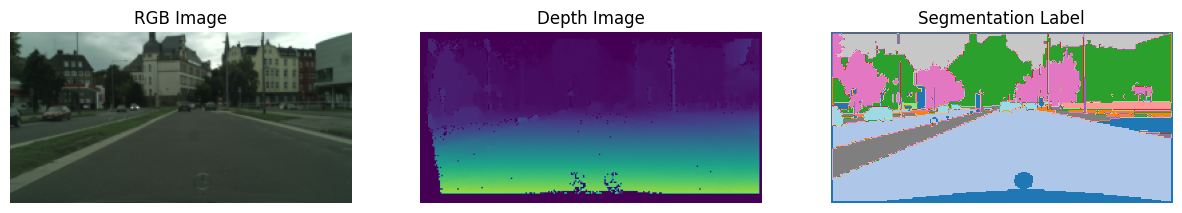

In [2]:
depth_folder = './train/depth'
rgb_folder = './train/image'
segmentation_label_folder = './train/label'

# Get the sorted list of file names to ensure they match by index
depth_files = sorted(os.listdir(depth_folder))
rgb_files = sorted(os.listdir(rgb_folder))
segmentation_label_files = sorted(os.listdir(segmentation_label_folder))

# Make sure each folder has the same number of files
assert len(depth_files) == len(rgb_files) == len(segmentation_label_files), "Mismatch in file counts across folders."

# Load the data
data = []
for i in range(len(depth_files)):
    depth_path = os.path.join(depth_folder, depth_files[i])
    rgb_path = os.path.join(rgb_folder, rgb_files[i])
    seg_label_path = os.path.join(segmentation_label_folder, segmentation_label_files[i])

    # Load each .npy file
    depth_img = np.load(depth_path)
    rgb_img = np.load(rgb_path)
    seg_label = np.load(seg_label_path)

    # Append a tuple of the loaded arrays
    data.append((depth_img, rgb_img, seg_label))

import matplotlib.pyplot as plt

# Retrieve the first image's data
depth_img, rgb_img, seg_label = data[1]

# Plot each component
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot RGB image
axes[0].imshow(rgb_img)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Plot Depth image
# Assuming depth data is a single channel, use a colormap to enhance visualization
axes[1].imshow(depth_img, cmap='viridis')
axes[1].set_title('Depth Image')
axes[1].axis('off')

# Plot Segmentation Label
# Assuming segmentation labels are integers, use a color map for clear separation
axes[2].imshow(seg_label, cmap='tab20')
axes[2].set_title('Segmentation Label')
axes[2].axis('off')

plt.show()

In [3]:
seg_label = data[0][2]

# Get unique classes in the segmentation label
unique_classes = np.unique(seg_label)
num_classes = len(unique_classes)
print(f"Unique classes in segmentation label: {unique_classes}")
print(f"Number of segmentation classes: {num_classes}")
print(to_categorical(seg_label).shape)

Unique classes in segmentation label: [-1.  0.  1.  2.  5.  7.  8.  9. 10. 11. 12. 13. 18.]
Number of segmentation classes: 13
(128, 256, 19)


Model with RGF Khush

In [4]:
def calculate_loss_between_segmentation_imgs(y_hat_n, y_n):
    pass

def residual_guided_fusion(input_shape_rgb, input_shape_depth, y_n, filters, num_classes):
    rgb_input = Input(shape=input_shape_rgb)
    depth_input = Input(shape=input_shape_depth)

    # RGB PATH
    # generate RGB predicted mask y_hat_n through a 1 × 1 convolutional layer
    y_hat_n = Conv2D(filters, kernel_size=(1, 1), padding='same')(rgb_input)
    loss_n = calculate_loss_between_segmentation_imgs(y_hat_n, y_n)
    y_res = Subtract()([y_n, y_hat_n])


    # DEPTH PATH
    # we subtract the RGB feature maps with depth feature maps by element-wise subtraction to get the difference between them. 
    difference_maps = Subtract()([depth_input, rgb_input])
    # The channel of the different features is adjusted to the number of classes through a 1 × 1 convolution.
    depth_conv = Conv2D(num_classes, kernel_size=(1, 1), padding='same')(difference_maps)
    skip = depth_conv

    # Then a residual unit with a 3 × 3convolution is used to generate the predicted residual mask y_hat_nres
    depth_conv = Conv2D(filters, kernel_size=(3, 3), padding='same')(depth_conv)
    y_hat_res = Add()([depth_conv, skip])

    loss_res = calculate_loss_between_segmentation_imgs(y_hat_res, y_res)

    # The channel of y_hat_res is adjusted to that of the RGB feature maps by a 1 ×1 convolution and result is fused with the RGB feature maps through an element-wise multiplication
    channels_rgb = input_shape_rgb[-1]
    y_hat_res_conv = Conv2D(channels_rgb, kernel_size=(1, 1), padding='same')(y_res)
    combined_path = Multiply()([y_hat_res_conv, rgb_input])

    stacked = Concatenate()([combined_path, rgb_input, y_hat_res_conv])

    return Conv2D(filters, kernel_size=(3, 3), padding='same')(stacked)

In [ ]:
print(data[0][0].shape, "Depth")
print(data[0][1].shape, "RGB")
print(data[0][2].shape, "Label")


(128, 256, 1) Depth
(128, 256, 3) RGB
(128, 256) Label


# RGF Parth

In [ ]:
def calculate_loss_between_segmentation_imgs(y_hat_n, y_n):
    pass

def residual_guided_fusion(rgb_input, depth_input, filters, y_n=None, num_classes=19):
    input_shape_rgb = rgb_input.shape
    input_shape_rgb = depth_input.shape

    # RGB PATH
    # generate RGB predicted mask y_hat_n through a 1 × 1 convolutional layer
    y_hat_n = Conv2D(filters, kernel_size=(1, 1), padding='same')(rgb_input)
    # loss_n = calculate_loss_between_segmentation_imgs(y_hat_n, y_n)
    # y_res = Subtract()([y_n, y_hat_n])


    # DEPTH PATH
    # we subtract the RGB feature maps with depth feature maps by element-wise subtraction to get the difference between them. 
    difference_maps = Subtract()([depth_input, rgb_input])
    # The channel of the different features is adjusted to the number of classes through a 1 × 1 convolution.
    depth_conv = Conv2D(filters, kernel_size=(1, 1), padding='same')(difference_maps)
    skip = depth_conv

    # Then a residual unit with a 3 × 3convolution is used to generate the predicted residual mask y_hat_nres
    depth_conv = Conv2D(filters, kernel_size=(3, 3), padding='same')(depth_conv)
    y_hat_res = Add()([depth_conv, skip])

    # loss_res = calculate_loss_between_segmentation_imgs(y_hat_res, y_res)

    # The channel of y_hat_res is adjusted to that of the RGB feature maps by a 1 ×1 convolution and result is fused with the RGB feature maps through an element-wise multiplication
    channels_rgb = input_shape_rgb[-1]
    y_hat_res_conv = Conv2D(channels_rgb, kernel_size=(1, 1), padding='same')(y_hat_res)
    combined_path = Multiply()([y_hat_res_conv, rgb_input])

    stacked = Concatenate()([combined_path, rgb_input, y_hat_res_conv])

    return Conv2D(filters, kernel_size=(3, 3), padding='same')(stacked)

In [ ]:
def encoder_block(inputs, filters):
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x, x

def decoder_block(inputs, skip_connection, filters, skip=True):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    if skip:
        if x.shape[1] != skip_connection.shape[1] or x.shape[2] != skip_connection.shape[2]:
            skip_connection = Conv2D(filters, kernel_size=(1, 1), padding='same')(skip_connection)
        x = Concatenate()([x, skip_connection])  # Skip connection

    return x

def calculate_loss_between_segmentation_imgs(y_hat_n, y_n):
    # Reshape y_hat_n to (batch_size, height, width, num_classes) if not already
    y_hat_n = tf.reshape(y_hat_n, [-1, *y_hat_n.shape[1:3], -1])
    
    # Reshape y_n to (batch_size, height, width)
    y_n = tf.reshape(y_n, [-1, *y_n.shape[1:3]])

    # Calculate sparse categorical cross-entropy
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_n, y_hat_n, from_logits=True))
    return loss


def residual_guided_fusion(rgb_decoder_out, depth_decoder_out, y_n, filters, num_classes):
    # RGB PATH
    # generate RGB predicted mask y_hat_n through a 1 × 1 convolutional layer
    y_hat_n = Conv2D(filters, kernel_size=(1, 1), padding='same')(rgb_decoder_out)
    y_res = Subtract()([y_n, y_hat_n])

    # DEPTH PATH
    # we subtract the RGB feature maps with depth feature maps by element-wise subtraction to get the difference between them. 
    difference_maps = Subtract()([depth_decoder_out, rgb_decoder_out])
    # The channel of the different features is adjusted to the number of classes through a 1 × 1 convolution.
    depth_conv = Conv2D(num_classes, kernel_size=(1, 1), padding='same')(difference_maps)
    skip = depth_conv

    # Then a residual unit with a 3 × 3convolution is used to generate the predicted residual mask y_hat_nres
    depth_conv = Conv2D(num_classes, kernel_size=(3, 3), padding='same')(depth_conv)
    y_hat_res = Add()([depth_conv, skip])

    # The channel of y_hat_res is adjusted to that of the RGB feature maps by a 1 ×1 convolution and result is fused with the RGB feature maps through an element-wise multiplication
    channels_rgb = rgb_decoder_out.shape[-1]
    y_hat_res_conv = Conv2D(channels_rgb, kernel_size=(1, 1), padding='same')(y_res)

    combined_path = Multiply()([y_hat_res_conv, rgb_decoder_out])

    stacked = Concatenate()([combined_path, rgb_decoder_out, y_hat_res_conv])

    return Conv2D(filters, kernel_size=(3, 3), padding='same')(stacked), y_hat_n, y_hat_res, y_res



def build_model(input_shape_rgb, input_shape_depth,input_shape_mask, num_classes = 19):
    rgb_input = Input(shape=input_shape_rgb)
    depth_input = Input(shape=input_shape_depth)
    mask_input = Input(shape=input_shape_mask)

    # Encoder for RGB
    rgb_enc1, rgb_skip1 = encoder_block(rgb_input, 32)
    rgb_enc2, rgb_skip2 = encoder_block(rgb_enc1, 64)
    rgb_enc3, rgb_skip3 = encoder_block(rgb_enc2, 128)

    # Encoder for Depth
    depth_enc1, depth_skip1 = encoder_block(depth_input, 32)
    depth_enc2, depth_skip2 = encoder_block(depth_enc1, 64)
    depth_enc3, depth_skip3 = encoder_block(depth_enc2, 128)

    # Decoder for Depth
    depth_dec3 = decoder_block(depth_enc3, depth_skip2, 128)
    depth_dec2 = decoder_block(depth_dec3, depth_skip1, 64)
    depth_dec1 = decoder_block(depth_dec2, None, 32, False)

    # Decoder for RGB
    rgb_dec3 = decoder_block(rgb_enc3, rgb_skip2, 128)
    rgb_dec3 = Add()([rgb_dec3, depth_dec3])

    rgb_dec2 = decoder_block(rgb_dec3, rgb_skip1, 64)
    rgb_dec2 = Add()([rgb_dec2, depth_dec2])

    rgb_dec1 = decoder_block(rgb_dec2, None, 32, False)
    rgb_dec1 = Add()([rgb_dec1, depth_dec1])

    # rgf module
    rgf_1, y_hat_n, y_hat_res, y_res = residual_guided_fusion(rgb_dec1, depth_dec1, mask_input, 32, num_classes)

    # Final output layer for RGB
    rgb_output = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax')(rgf_1)
    
# (input_shape_rgb, input_shape_depth, y_n, filters, num_classes):
    # Create model
    model = Model(inputs=[rgb_input, depth_input, mask_input], outputs=rgb_output)
    return model

# Example usage
input_shape_rgb = (128, 256, 3)
input_shape_depth = (128, 256, 1)
input_shape_mask = (128, 256, 1)
model = build_model(input_shape_rgb, input_shape_depth, input_shape_mask)
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[MeanIoU(num_classes=19)])

# data generator